# **Waze Project**

 ## **Case Study**
Waze’s free navigation app makes it easier for drivers around the world to get to where they want to go. Waze’s community of map editors, beta testers, translators, partners, and users helps make each drive better and safer. Waze partners with cities, transportation authorities, broadcasters, businesses, and first responders to help as many people as possible travel more efficiently and safely. 

The Management of Waze company in a bid to increase growth, wants to improve their users experience and as a result, prevent  Users churn. Churn quantifies the number of users who have uninstalled the Waze app or stopped using the app. This project focuses on monthly user churn. 

Our **Goal**: Develope a churn prediction model thaat will help prevent churn, improve user retention, and grow Waze’s business. An accurate model can also help identify specific factors that contribute to churn and answer questions such as: 

* Who are the users most likely to churn?
* Why do users churn?
* When do users churn?

if Waze can identify a segment of users who are at high risk of churning, Waze can proactively engage these users with special offers to try and retain them. Otherwise, Waze may lose these users without knowing why. 

This project will help Waze leadership optimize the company’s retention strategy, enhance user experience, and make data-driven decisions about product development.

***This activity has three parts:***

**Part 1:** Ethical considerations
* we'll Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* we'll Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* we'll Build the following models
    * Random Forest Model
    * XGBoost model
*  evaluate them, and advise on next steps

#### Modeling design and target variable

The dataset dictionary shows that there is a column called `label`. This is a binary value that indicates whether a user will churn or be retained. This will be the target variable. In other words, for each user, the model should predict whether the user will churn or be retained.

This is a classification task because the model is predicting a binary class.

# **Build a machine learning model**

Throughout these project notebooks, we'll reference to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

## **PACE: Plan**

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, we'll consider the following questions:

1.   What are we being asked to do?
> _Predict if a customer will churn or be retained._

2.   What are the ethical implications of the model? What are the consequences of our model making errors?
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a Waze user won't churn, but they actually will)?
  > _Waze will fail to take proactive measures to retain users who are likely to stop using the app. For example, Waze might proactively push an app notification to users, or send a survey to better understand user dissatisfaction._
  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a Waze user will churn, but they actually won't)?
  > _Waze may take proactive measures to retain users who are NOT likely to churn. This may lead to an annoying or negative experience for loyal users of the app._
3.   Do the benefits of such a model outweigh the potential problems?
  > _The proactive measueres taken by Waze might have unintended effects on users, and these effects might encourage user churn. Follow-up analysis on the effectiveness of the measures is recommended. If the measures are reasonable and effective, then the benefits will most likely outweigh the problems._
4.   Would you proceed with the request to build this model? Why or why not?

  >_Yes. There aren't any significant risks for building such a model._


### Familiarize Ourselves with the Dataset

#### **`sessions`**
The number of occurrences of a user opening the app during the month

#### **`drives`**

_An occurrence of driving at least 1 km during the month_

#### **`total_sessions`**

_A model estimate of the total number of sessions since a user has onboarded_

#### **`n_days_after_onboarding`**

_The number of days since a user signed up for the app_

#### **`driven_km_drives`**

_Total kilometers driven during the month_

#### **`duration_minutes_drives`**

_Total duration driven in minutes during the month_

#### **`activity_days`**

_Number of days the user opens the app during the month_

#### **`driving_days`**

_Number of days the user drives (at least 1 km) during the month_

#### **`device`**

_The type of device a user starts a session with_

### **Task 1. Imports and data loading**


Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [2]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

Now read in the dataset as `df0` and inspect the first five rows.

In [3]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [4]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [5]:
df0.label.unique()

array(['retained', 'churned', nan], dtype=object)

## **PACE: Analyze**
Consider the questions in your PACE Strategy Document to reflect on the Analyze stage.

we'll Analyze and discover data, looking for correlations, missing data, potential outliers, and/or duplicates.

In [6]:
print(df0.shape)

df0.info()

(14999, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### Data types contained in the dataset
Get the data types of the columns.

In [7]:
# Get data types of columns
df0.dtypes

ID                           int64
label                       object
sessions                     int64
drives                       int64
total_sessions             float64
n_days_after_onboarding      int64
total_navigations_fav1       int64
total_navigations_fav2       int64
driven_km_drives           float64
duration_minutes_drives    float64
activity_days                int64
driving_days                 int64
device                      object
dtype: object

#### Missing values 
Lets check for and handle missing values.

In [8]:
# Check for missing values
df0.isna().sum()

ID                           0
label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64

We have 700 missing values in the Label column which is our outcome variable.

lets check the percentage of the missing vakues

In [9]:
print(round(700/df0.shape[0]*100,2),'%')

4.67 %


The missing rows are not up to 5% therefore we will proceed to drop them

#### Drop Missing values
We will drop the rows with the missing values as they are less than 2% of the data rows

In [10]:
# Drop rows with missing values
df0 = df0.dropna(axis=0)

In [11]:
#re checking the size of the data after droping NaN
df0.shape

(14299, 13)

#### **`sessions`**

_The number of occurrences of a user opening the app during the month_

### **Task 2. Feature engineering & Analysis**

We will performed exploratory data analysis (EDA) on this dataset to understand which features has stronger correlation with our Predictor variable `label` than others, and we'll also create some features that may be useful.

In this part of the project, we'll engineer these features and some new features to use for modeling.

To begin, create a copy of `df0` to preserve the original dataframe. Call the copy `df`.

#### Check Duplicates 
Check for and handle duplicates.

In [12]:
# Check for duplicates
df0.duplicated().sum()

0

No duplicates are contained in the data

In [13]:
# Copy the df0 dataframe
df = df0.copy()

#### **`driving_days` vs. `activity_days`**

Because both `driving_days` and `activity_days` represent counts of days over a month and they're also closely related, you can plot them together on a single histogram. This will help to better understand how they relate to each other without having to scroll back and forth comparing histograms in two different places.

Plot a histogram that, for each day, has a bar representing the counts of `driving_days` and `user_days`.

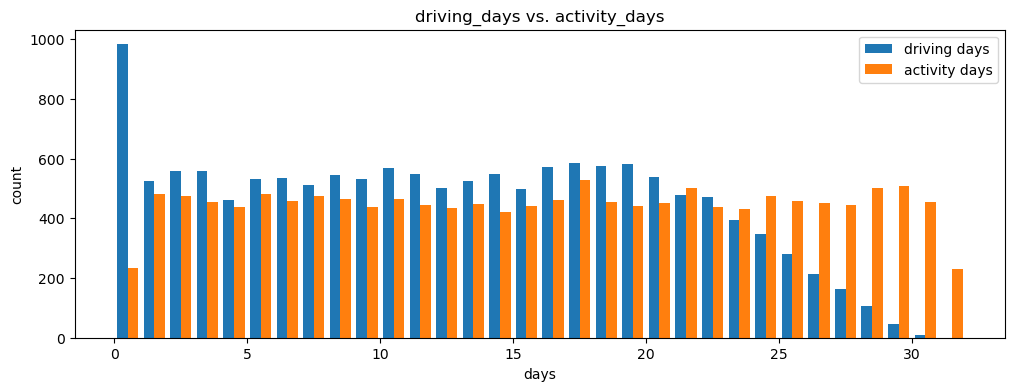

In [14]:
# Histogram
plt.figure(figsize=(12,4))
label=['driving days', 'activity days']
plt.hist([df['driving_days'], df['activity_days']],
         bins=range(0,33),
         label=label)
plt.xlabel('days')
plt.ylabel('count')
plt.legend()
plt.title('driving_days vs. activity_days');

#### Observation:
There are people who drive without opening the App, this might seem counterintuitive.

On the other hand, it could just be illustrative of the fact that, while these variables are related to each other, they're not the same. People probably just open the app more than they use the app to drive&mdash;perhaps to check drive times or route information, to update settings, or even just by mistake.

Nonetheless, it might be worthwile to contact the data team at Waze to get more information about this, especially because it seems that the number of days in the month is not the same between variables.

Confirm the maximum number of days for each variable&mdash;`driving_days` and `activity_days`.

In [15]:
print(df['driving_days'].max())
print(df['activity_days'].max())

30
31


It's true. Although it's possible that not a single user drove all 31 days of the month, it's highly unlikely, considering there are 15,000 people represented in the dataset.

One other way to check the validity of these variables is to plot a simple scatter plot with the x-axis representing one variable and the y-axis representing the other.

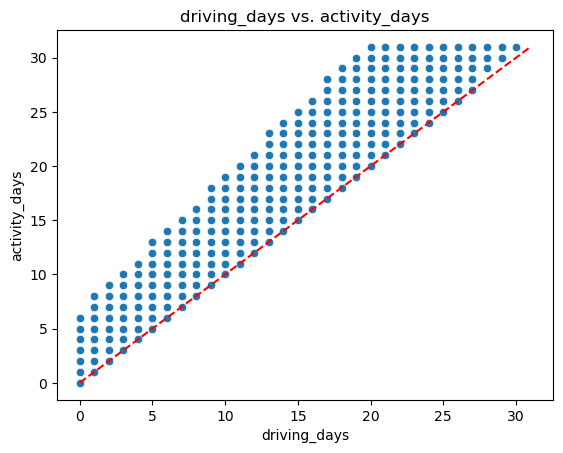

In [16]:
# Scatter plot
sns.scatterplot(data=df, x='driving_days', y='activity_days')
plt.title('driving_days vs. activity_days')
plt.plot([0,31], [0,31], color='red', linestyle='--');

#### Observation:
Notice that there is a theoretical limit. If you use the app to drive, then by definition it must count as a day-use as well. In other words, you cannot have more drive-days than activity-days. None of the samples in this data violate this rule, which is good.

#### **Retention by device**

Plot a histogram that has four bars&mdash;one for each device-label combination&mdash;to show how many iPhone users were retained/churned and how many Android users were retained/churned.

C:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


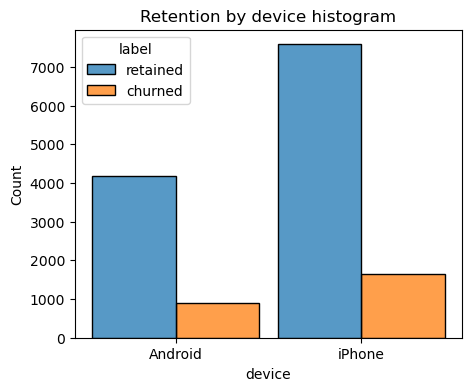

In [17]:
# Histogram
plt.figure(figsize=(5,4))
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.title('Retention by device histogram');

### **Feature Engineering**
We will need to create Features to enable us draw meaningful insights from the dataset

#### **`km_per_driving_day`**

You know from earlier EDA that churn rate correlates with distance driven per driving day in the last month. It might be helpful to engineer a feature that captures this information.

1. Create a new column in `df` called `km_per_driving_day`, which represents the mean distance driven per driving day for each user.

2. Call the `describe()` method on the new column.

In [18]:
df['km_per_driving_day'] = df['driven_km_drives']/df['driving_days']

df['km_per_driving_day'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.675616e+02
50%      3.241789e+02
75%      7.608293e+02
max               inf
Name: km_per_driving_day, dtype: float64

**Note** that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

1. Convert these values from infinity to zero. You can use `np.inf` to refer to a value of infinity.

2. Call `describe()` on the `km_per_driving_day` column to verify that it worked.

In [19]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14299.000000
mean       581.942399
std       1038.254509
min          0.000000
25%        136.168003
50%        273.301012
75%        558.018761
max      15420.234110
Name: km_per_driving_day, dtype: float64

The maximum value is 15,420 kilometers _per drive day_. This is physically impossible. Driving 100 km/hour for 12 hours is 1,200 km. It's unlikely many people averaged more than this each day they drove, so, for now, we'll disregard rows where the distance in this column is greater than 1,200 km.

We'll plot a histogram of the new `km_per_driving_day` column, disregarding those users with values greater than 1,200 km. Each bar should be the same length and have two colors, one color representing the percent of the users in that bar that churned and the other representing the percent that were retained. This can be done by setting the `multiple` parameter of seaborn's [`histplot()`](https://seaborn.pydata.org/generated/seaborn.histplot.html) function to `fill`.

In [20]:
df[['km_per_driving_day', 'label']].groupby('label').median()

,km_per_driving_day
label,
churned,407.597934
retained,256.056187


C:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


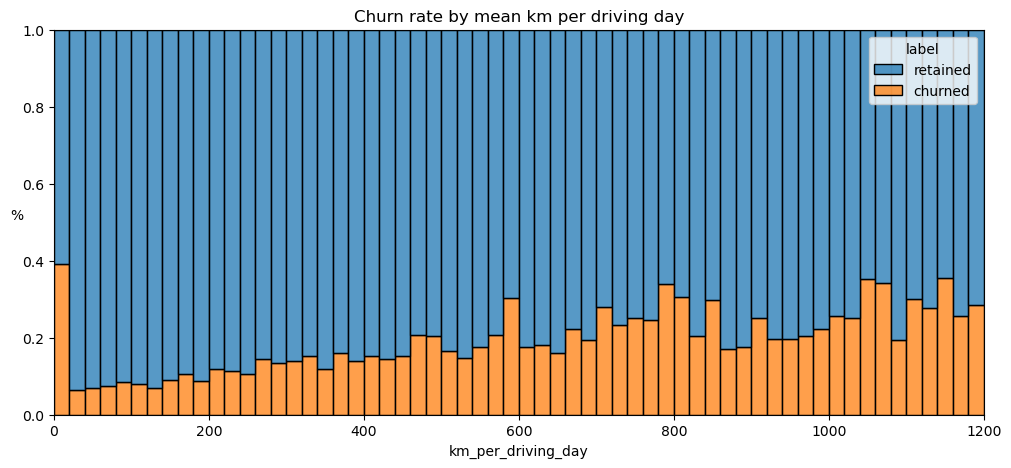

In [21]:
# Histogram
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='km_per_driving_day',
             bins=range(0,1201,20),
             hue='label',
             multiple='fill')
plt.ylabel('%', rotation=0)
plt.title('Churn rate by mean km per driving day');

#### Observation:
The churn rate tends to increase as the mean daily distance driven increases. It would be worth investigating further the reasons for long-distance users to discontinue using the app.

#### **Churn rate per number of driving days**

We'll create another histogram just like the previous one, only this time it should represent the churn rate for each number of driving days.

C:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


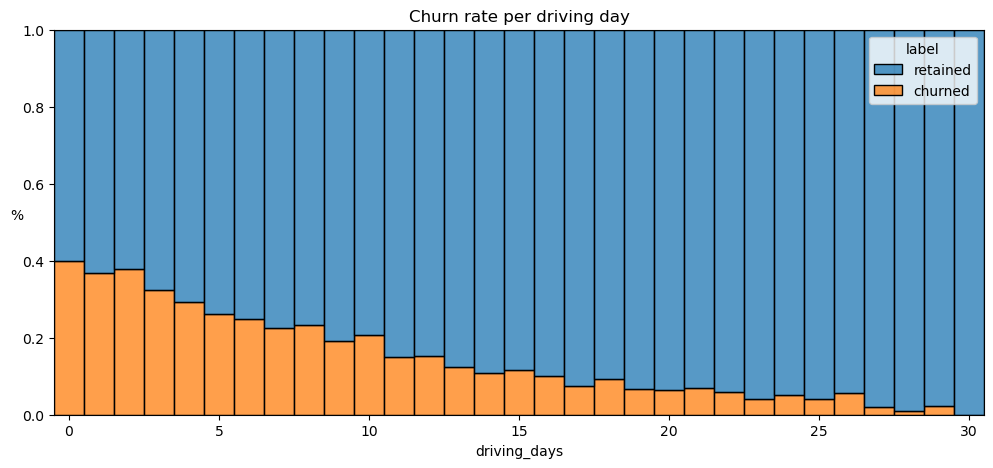

In [22]:
# Histogram
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='driving_days',
             bins=range(1,32),
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Churn rate per driving day');

#### Observation:
The churn rate is highest for people who didn't use Waze much during the last month. The more times they used the app, the less likely they were to churn. While 40% of the users who didn't use the app at all last month churned, nobody who used the app 30 days churned.

This isn't surprising. If people who used the app a lot churned, it would likely indicate dissatisfaction. When people who don't use the app churn, it might be the result of dissatisfaction in the past, or it might be indicative of a lesser need for a navigational app. Maybe they moved to a city with good public transportation and don't need to drive anymore.

#### **Retention by kilometers driven per driving day**

In the previous course, you discovered that the median distance driven per driving day last month for users who churned was 608.78 km, versus 247.48 km for people who did not churn. Examine this further.

1. Create a new column in `df` called `km_per_driving_day`, which represents the mean distance driven per driving day for each user.

2. Call the `describe()` method on the new column.

#### Observation:
The proportion of churned users to retained users is consistent between device types.

#### **Encode categorical variables**

we'll Change the data type of the `label` column to be binary. This change is needed to find correlations with other Categorical Features.

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

Save this variable as `label2` as to not overwrite the original `label` variable.

**Note:** There are many ways to do this. we'll use `np.where()`

In [23]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


#### Establishing Correlation 

In [24]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,label2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0


In [25]:
# Generate a correlation matrix
df.corr(method='pearson',numeric_only=True)

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,label2
ID,1.000000,0.012516,0.011741,0.005986,-0.005300,-0.000560,0.000153,-0.002123,-0.000181,-0.000891,-0.000981,-0.005151,0.004425
sessions,0.012516,1.000000,0.996843,0.590265,0.006441,0.005252,0.005220,0.003815,-0.005800,0.024594,0.020228,-0.008961,0.038045
drives,0.011741,0.996843,1.000000,0.588118,0.006001,0.004551,0.006896,0.003708,-0.005376,0.024324,0.019975,-0.008772,0.038548
total_sessions,0.005986,0.590265,0.588118,1.000000,0.006180,-0.000047,0.007659,0.001690,-0.001457,0.012932,0.009798,-0.015169,0.025046
n_days_after_onboarding,-0.005300,0.006441,0.006001,0.006180,1.000000,-0.004536,-0.006433,-0.005056,-0.010715,-0.009418,-0.007321,0.011764,-0.129263
total_navigations_fav1,-0.000560,0.005252,0.004551,-0.000047,-0.004536,1.000000,0.003734,-0.006262,0.005619,0.010318,0.010024,-0.000171,0.055537
total_navigations_fav2,0.000153,0.005220,0.006896,0.007659,-0.006433,0.003734,1.000000,0.000159,-0.005326,-0.004836,0.000938,0.008992,0.020051
driven_km_drives,-0.002123,0.003815,0.003708,0.001690,-0.005056,-0.006262,0.000159,1.000000,0.697977,-0.004196,-0.007099,0.355674,0.019050
duration_minutes_drives,-0.000181,-0.005800,-0.005376,-0.001457,-0.010715,0.005619,-0.005326,0.697977,1.000000,-0.003898,-0.006239,0.245978,0.035678
activity_days,-0.000891,0.024594,0.024324,0.012932,-0.009418,0.010318,-0.004836,-0.004196,-0.003898,1.000000,0.947687,-0.397433,-0.303851


In [26]:
# Plot correlation heatmap

corr = df[["sessions", "drives", "total_sessions", "n_days_after_onboarding","driving_days", "label2",
                    "total_navigations_fav1", "total_navigations_fav2", "driven_km_drives", "duration_minutes_drives", "activity_days"]].corr(numeric_only=True)
corr.style.background_gradient(cmap='RdBu',vmin =-1, vmax =1).format(precision=3)




,sessions,drives,total_sessions,n_days_after_onboarding,driving_days,label2,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days
sessions,1.000,0.997,0.590,0.006,0.020,0.038,0.005,0.005,0.004,-0.006,0.025
drives,0.997,1.000,0.588,0.006,0.020,0.039,0.005,0.007,0.004,-0.005,0.024
total_sessions,0.590,0.588,1.000,0.006,0.010,0.025,-0.000,0.008,0.002,-0.001,0.013
n_days_after_onboarding,0.006,0.006,0.006,1.000,-0.007,-0.129,-0.005,-0.006,-0.005,-0.011,-0.009
driving_days,0.020,0.020,0.010,-0.007,1.000,-0.294,0.010,0.001,-0.007,-0.006,0.948
label2,0.038,0.039,0.025,-0.129,-0.294,1.000,0.056,0.020,0.019,0.036,-0.304
total_navigations_fav1,0.005,0.005,-0.000,-0.005,0.010,0.056,1.000,0.004,-0.006,0.006,0.010
total_navigations_fav2,0.005,0.007,0.008,-0.006,0.001,0.020,0.004,1.000,0.000,-0.005,-0.005
driven_km_drives,0.004,0.004,0.002,-0.005,-0.007,0.019,-0.006,0.000,1.000,0.698,-0.004
duration_minutes_drives,-0.006,-0.005,-0.001,-0.011,-0.006,0.036,0.006,-0.005,0.698,1.000,-0.004


#### Observation:
we can  see that these Features correlate with the our predictor variable 
* `total_navigations_fav1`
* `drives`
* `sessions`               
* `duration_minutes_drives`
* `total_sessions`
* `total_navigations_fav2`
* `driven_km_drives`
* `driving_days`


#### **`percent_sessions_in_last_month`**
1. We'll create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

2. Get descriptive statistics for this new feature

In [27]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 2. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14299.000000
mean         0.449837
std          0.286863
min          0.000000
25%          0.196890
50%          0.424310
75%          0.687251
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**

We create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

To create this column, we use the [`np.where()`](https://numpy.org/doc/stable/reference/generated/numpy.where.html) function. This function accepts as arguments:
1. A condition
2. What to return when the condition is true
3. What to return when the condition is false

```
Example:
x = [1, 2, 3]
x = np.where(x > 2, 100, 0)
x
array([  0,   0, 100])

In [28]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [29]:
df['professional_driver'].describe()

count    14299.000000
mean         0.173998
std          0.379121
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: professional_driver, dtype: float64

#### **`total_sessions_per_day`**

Now, we 'll create a new column that represents the mean number of sessions per day _since onboarding_.

In [30]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

As with other features, we'll get descriptive statistics for this new feature.

In [31]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14299.000000
mean         0.338207
std          1.319814
min          0.000298
25%          0.050818
50%          0.100457
75%          0.215210
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

Create a column representing the mean kilometers per hour driven in the last month.

In [32]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14299.000000
mean       190.730963
std        339.926138
min         72.013095
25%         90.649402
50%        122.105845
75%        193.238449
max      23642.920871
Name: km_per_hour, dtype: float64

These numbers are obviously problematic, and it would be worthwhile to seek clarification from Waze regarding how these features are collected to better understand why such unrealistic speeds are observed.

#### **`km_per_drive`**

Create a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature.

In [33]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.325389e+01
50%      7.490594e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too.We'll convert the infinite values to zero, then confirm that it worked.

In [34]:
# 1. Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14299.000000
mean       232.269197
std        616.197409
min          0.000000
25%         32.486524
50%         72.947059
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Finally, we'll create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. Then, print descriptive statistics for the new column.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [35]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14299.000000
mean         1.676347
std          9.021250
min          0.000000
25%          0.206064
50%          0.653572
75%          1.643183
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

### **Task 3. Outliers**

You know from previous EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Task 4. Variable encoding**

#### **Dummying features**

In order to use `device` as an X variable, we'll will need to convert it to binary, since this variable is categorical.

In cases where the data contains many categorical variables, we can use pandas built-in [`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), or we can use scikit-learn's [`OneHotEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function.

**Note:** Each possible category of each feature will result in a feature for your model, which could lead to an inadequate ratio of features to observations and/or difficulty understanding your model's predictions.

Because this dataset only has one remaining categorical feature (`device`), it's not necessary to use one of these special functions. we can just implement the transformation directly.

We'll create a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [36]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


### **Task 5. Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

Note, however, that `device` won't be used simply because it's a copy of `device2`.

Drop `ID` from the `df` dataframe.

In [37]:
# Drop `ID` column
df = df.drop(['ID'], axis=1)

### **Task 6. Evaluation metric**

Before modeling, you must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, examine the class balance of your target variable.

In [38]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, we'll consider which evaluation metric is best. Remember, accuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, we'll select the model based on the recall score.

## **PACE: Construct**
Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 7. Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/validation/test sets.

1. Define a variable `X` that isolates the features. Remember not to use `device`.

2. Define a variable `y` that isolates the target variable (`label2`).

3. Split the data 80/20 into an interim training set and a test set. Don't forget to stratify the splits, and set the random state to 42.

4. Split the interim training set 75/25 into a training set and a validation set, yielding a final ratio of 60/20/20 for training/validation/test sets. Again, don't forget to stratify the splits and set the random state.

In [39]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

Verify the number of samples in the partitioned data.

In [40]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


Just like we expected.

In [41]:
X_train.columns

Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'driving_days',
       'km_per_driving_day', 'percent_sessions_in_last_month',
       'professional_driver', 'total_sessions_per_day', 'km_per_hour',
       'km_per_drive', 'percent_of_drives_to_favorite', 'device2'],
      dtype='object')

### **Task 8. Modeling**

#### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.
 - `max_depth`
 - `max_features`
 - `max_samples`
 - `min_samples_leaf`
 - `min_samples_split`
 - `n_estimators`

3. Define a set `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf_cv`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

 `refit` should be set to `'recall'`.<font/>

In [42]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [7, None],
             'max_features': [0.8, 1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [2, 3],
             'n_estimators': [200, 300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

We now fit the model

In [43]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 47min 5s
Wall time: 47min 16s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [7, None], 'max_features': [0.8, 1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [200, 300]},
             refit='recall', scoring={'f1', 'accuracy', 'recall', 'precision'})

We will now examine the best average score across all the validation folds.

In [44]:
# Examine best score
rf_cv.best_score_

0.13204171846940185

Examine the best combination of hyperparameters.

In [45]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

We'll create a helper function `make_results()` to output all of the scores of our model.

In [46]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

we'll Pass the `GridSearch` object to the `make_results()` function.

In [47]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.451745,0.132042,0.204309,0.817694


#### Observation:
Asside from the accuracy, the scores aren't that good. However,which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.

We can further tune our hyperparameters to try to get a better score. we might be able to marginally improve the model.

#### **XGBoost**

To improve our scores using an XGBoost model. We'll do the following
1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a set `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb_cv`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='recall'`)

In [48]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4, 8, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

Now we'll fit the model to the `X_train` and `y_train` data.

Note this cell might take several minutes to run.

In [49]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 43min 31s
Wall time: 6min 12s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'f1', 'accuracy', 'recall', 'precision'})

We'll get the best score from this model.

In [50]:
# Examine best score
xgb_cv.best_score_

0.1760947644702307

And the best parameters.

In [51]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 3,
 'n_estimators': 500}

We'll se the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [52]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.451745,0.132042,0.204309,0.817694
0,XGB cv,0.419592,0.176095,0.247733,0.810817


#### Observation:
This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### **Task 9. Model selection**

Now, we'll use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [53]:
# We random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

We'll use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [54]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [55]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.451745,0.132042,0.204309,0.817694
0,XGB cv,0.419592,0.176095,0.247733,0.810817
0,RF val,0.443038,0.138067,0.210526,0.816434


Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [56]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.451745,0.132042,0.204309,0.817694
0,XGB cv,0.419592,0.176095,0.247733,0.810817
0,RF val,0.443038,0.138067,0.210526,0.816434
0,XGB val,0.395122,0.159763,0.227528,0.807692


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

## **PACE: Execute**
We'll consider the questions in our PACE Strategy Document to reflect on the Execute stage.

### **Task 10. Use champion model to predict on test data**

Now, we'll use the champion model to predict on the test dataset. This is to give a final indication of how we should expect the model to perform on new future data, should we decide to use the model.

In [57]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.451745,0.132042,0.204309,0.817694
0,XGB cv,0.419592,0.176095,0.247733,0.810817
0,RF val,0.443038,0.138067,0.210526,0.816434
0,XGB val,0.395122,0.159763,0.227528,0.807692
0,XGB test,0.378723,0.175542,0.239892,0.802797


#### Observation:
The Champion Model performed better with the test data across all metrics. 

### **Task 11. Confusion matrix**

we'll Plot a confusion matrix of the champion model's predictions on the test data.

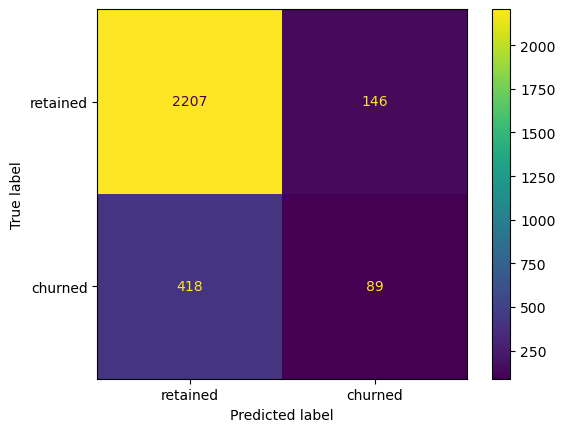

In [58]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

#### Observation:
The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

### **Task 11. Feature importance**

Use the `plot_importance` function to inspect the most important features of your final model.

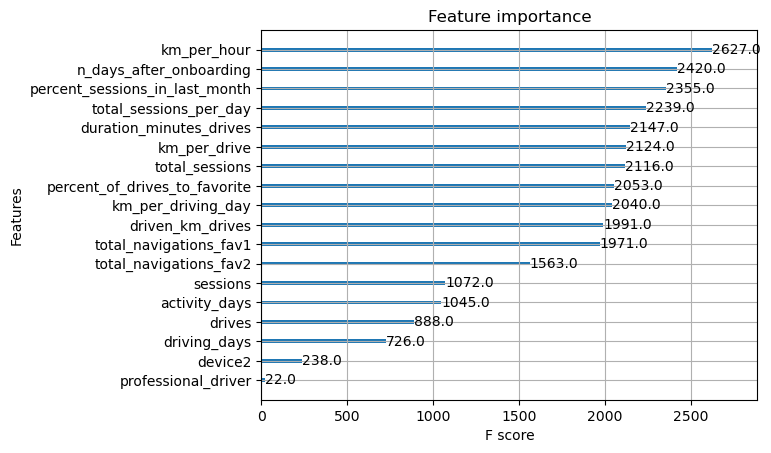

In [59]:
plot_importance(xgb_cv.best_estimator_);

#### Observation:

This underscores the importance of feature engineering. Notice that engineered features accounted for six of the top 10 features (and three of the top five). Feature engineering is often one of the best and easiest ways to boost model performance.

Also, note that the important features in one model might not be the same as the important features in another model. That's why you shouldn't discount features as unimportant without thoroughly examining them and understanding their relationship with the dependent variable, if possible. These discrepancies between features selected by models are typically caused by complex feature interactions.

Remember, sometimes our data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.

Even if you cannot use the model to make strong predictions, was the work done in vain? What insights can you report back to stakeholders?

### **Task 15. Conclusion**

Now that we've built and tested our machine learning models, the next step is to share our findings with the Waze leadership team. The following are our recommendations


1. Would you recommend using this model for churn prediction? Why or why not?

> _It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._

2. What tradeoff was made by splitting the data into training, validation, and test sets as opposed to just training and test sets?

> _Splitting the data three ways means that there is less data available to train the model than splitting just two ways. However, performing model selection on a separate validation set enables testing of the champion model by itself on the test set, which gives a better estimate of future performance than splitting the data two ways and selecting a champion model by performance on the test data._

3. What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?

> _Logistic regression models are easier to interpret. Because they assign coefficients to predictor variables, they reveal not only which features factored most heavily into their final predictions, but also the directionality of the weight. In other words, they tell you if each feature is positively or negatively correlated with the target in the model's final prediction._

4. What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?

> _Tree-based model ensembles are often better predictors. If the most important thing is the predictive power of the model, then tree-based modeling will usually win out against logistic regression (but not always!). They also require much less data cleaning and require fewer assumptions about the underlying distributions of their predictor variables, so they're easier to work with._

5. What could you do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, the engineered features made up over half of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

6. What additional features would you like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._
